In [1]:
%matplotlib inline


from neuron import h
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import h5py
import os

from cell_inference.utils.plotting.plot_results import plot_lfp_traces, plot_lfp_heatmap
from cell_inference.utils.feature_extractors.SummaryStats2D import calculate_stats, build_lfp_grid
from cell_inference.cells.stylizedcell import CellTypes
from cell_inference.cells.activecell import ActiveCell
from cell_inference.cells.passivecell import PassiveCell
from cell_inference.cells.simulation import Simulation
from cell_inference.utils.currents.recorder import Recorder
from cell_inference.config import paths, params
from cell_inference.utils.feature_extractors.parameterprediction import ClassifierTypes, ClassifierBuilder

cell_type = CellTypes.ACTIVE

h.nrn_load_dll(paths.COMPILED_LIBRARY)
geo_standard = pd.read_csv(paths.GEO_STANDARD,index_col='id')
h.tstop = params.TSTOP
h.dt = params.DT

In [2]:
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere


DATA_PATH = 'cell_inference/resources/simulation_data'
TRIAL_PATH = os.path.join(DATA_PATH, 'Loc2Alt_Ori2_Geo3_params')

LFP_PATH = os.path.join(TRIAL_PATH, 'lfp.npz')  # LFP and labels

lfp   = np.load(LFP_PATH)['x']
print(lfp.shape)
labels = np.load(LFP_PATH)['y']
print(labels.shape)

(1000, 176, 384)
(1000, 7)


In [3]:
from tqdm.notebook import tqdm

summ_stats = []
for i in tqdm(range(lfp.shape[0])):
    g_lfp, _ = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION, y_window_size=960.0)
    summ_stats.append(calculate_stats(g_lfp))
summ_stats = np.array(summ_stats)

  0%|          | 0/1000 [00:00<?, ?it/s]

If the user sends h and phi parameters and wants the model to learn directional vectors for orientation, enable this code block

In [4]:
convert_hphi_to_dv = False

if convert_hphi_to_dv:
#     hphi_labels = labels
    dv = hphi2unitsphere(labels)
    dvx, dvy, dvz = tuple(np.hsplit(dv, 3))
    labels = np.concatenate((dvx, dvy, dvz), axis=1)
    print(labels.shape)

In [5]:
import json

CONFIG_PATH = os.path.join(TRIAL_PATH, 'config.json')

with open(CONFIG_PATH, 'r') as f:
    config = json.load(f)

inference_list = config['Trial_Parameters']['inference_list']
print(inference_list)
ranges = config['Simulation_Parameters']['loc_param_range']
ranges.update(config['Simulation_Parameters']['geo_param_range'])
feature_range = (-1, 1)

normalize_labels = True

if normalize_labels:
    for i in range(labels.shape[1]):
        label = labels[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        x_std = (label - min_max_range[0]) / (min_max_range[1] - min_max_range[0])
        x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
        labels[:,i] = x_scaled
    print(labels)

['d', 'theta', 'h', 'phi', 'r_s', 'l_t', 'r_t']
[[-0.54532796  0.19950308  0.2467447  ...  0.78257079 -0.95830196
   0.01884223]
 [-0.36648332 -0.83769703 -0.33564824 ... -0.10318346 -0.03745967
  -0.99991956]
 [ 0.59473091  0.05853246 -0.31366349 ... -0.15249521  0.96449401
  -0.76405391]
 ...
 [-0.26264348 -0.37940062  0.95769607 ...  0.23478598  0.82764779
  -0.75374182]
 [-0.01424659 -0.12016722  0.92645932 ... -0.40433452  0.83934002
   0.84983729]
 [-0.1353533  -0.07019125  0.14896279 ...  0.81742647 -0.38685954
  -0.7928324 ]]


In [6]:
from cell_inference.utils.feature_extractors.helperfunctions import train_regression, build_dataloader_from_numpy

data = summ_stats
print(data.shape)

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=2)

(1000, 40)


In [7]:
from cell_inference.utils.feature_extractors.fullyconnectednetwork import FullyConnectedNetwork, ActivationTypes
from cell_inference.utils.feature_extractors.convolutionalnetwork import ConvolutionalNetwork
import torch

# model1 = ConvolutionalNetwork(in_channels=1, num_labels=2)
# model1 = torch.load('cell_inference/resources/results/pytorch_models/16_23_59__01_04_2022.pt')
model1 = FullyConnectedNetwork(in_features=40, out_features=7)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #torch.device("cpu")
model1.to(device)

train_regression(model1, train_loader, test_loader, 300, learning_rate=0.001, decay_rate=0.99, device=device)

  0%|          | 1/300 [00:01<05:27,  1.10s/it]

Training Loss: 103.43000062555075 Validation Loss: 29.683972004801035


  4%|▎         | 11/300 [00:11<05:10,  1.07s/it]

Training Loss: 71.42889929562807 Validation Loss: 23.3936705365777


  7%|▋         | 21/300 [00:22<04:57,  1.07s/it]

Training Loss: 59.47405522316694 Validation Loss: 21.43339203298092


 10%|█         | 31/300 [00:33<04:48,  1.07s/it]

Training Loss: 53.73504536226392 Validation Loss: 21.02596765011549


 14%|█▎        | 41/300 [00:43<04:35,  1.06s/it]

Training Loss: 43.86868944577873 Validation Loss: 21.446045394986868


 17%|█▋        | 51/300 [00:54<04:30,  1.09s/it]

Training Loss: 36.36024937406182 Validation Loss: 22.480119816958904


 20%|██        | 61/300 [01:05<04:07,  1.03s/it]

Training Loss: 29.267651760019362 Validation Loss: 21.713170278817415


 24%|██▎       | 71/300 [01:15<03:50,  1.01s/it]

Training Loss: 23.888149544596672 Validation Loss: 23.637512661516666


 27%|██▋       | 81/300 [01:25<03:41,  1.01s/it]

Training Loss: 19.869283518753946 Validation Loss: 24.436556097120047


 30%|███       | 91/300 [01:35<03:31,  1.01s/it]

Training Loss: 17.556066572666168 Validation Loss: 25.219030179083347


 34%|███▎      | 101/300 [01:45<03:20,  1.01s/it]

Training Loss: 16.164789753500372 Validation Loss: 24.862013317644596


 37%|███▋      | 111/300 [01:55<03:10,  1.01s/it]

Training Loss: 14.709724163636565 Validation Loss: 25.23947199434042


 40%|████      | 121/300 [02:05<03:03,  1.02s/it]

Training Loss: 13.359859716147184 Validation Loss: 24.90808729827404


 44%|████▎     | 131/300 [02:15<02:50,  1.01s/it]

Training Loss: 12.139344863593578 Validation Loss: 23.96679273992777


 47%|████▋     | 141/300 [02:25<02:39,  1.01s/it]

Training Loss: 10.99911847896874 Validation Loss: 24.25526201725006


 50%|█████     | 151/300 [02:35<02:30,  1.01s/it]

Training Loss: 10.687987580895424 Validation Loss: 24.041912611573935


 54%|█████▎    | 161/300 [02:45<02:16,  1.02it/s]

Training Loss: 9.903028727741912 Validation Loss: 24.32713419944048


 57%|█████▋    | 171/300 [02:55<02:09,  1.00s/it]

Training Loss: 9.198064196622 Validation Loss: 24.532540313899517


 60%|██████    | 181/300 [03:05<01:57,  1.01it/s]

Training Loss: 8.36158468190115 Validation Loss: 25.02714867889881


 64%|██████▎   | 191/300 [03:15<01:49,  1.01s/it]

Training Loss: 7.889016126748174 Validation Loss: 25.177055664360523


 67%|██████▋   | 201/300 [03:25<01:40,  1.02s/it]

Training Loss: 7.559059466933832 Validation Loss: 24.99931339174509


 70%|███████   | 211/300 [03:35<01:29,  1.01s/it]

Training Loss: 7.2393729742616415 Validation Loss: 25.308979474008083


 74%|███████▎  | 221/300 [03:45<01:19,  1.01s/it]

Training Loss: 6.878513248288073 Validation Loss: 25.8058867380023


 77%|███████▋  | 231/300 [03:55<01:05,  1.06it/s]

Training Loss: 6.727906001498923 Validation Loss: 25.901789247989655


 80%|████████  | 241/300 [04:05<00:55,  1.06it/s]

Training Loss: 6.4194085274939425 Validation Loss: 26.150816097855568


 84%|████████▎ | 251/300 [04:14<00:49,  1.00s/it]

Training Loss: 6.260662508342648 Validation Loss: 26.159284252673388


 87%|████████▋ | 261/300 [04:24<00:39,  1.01s/it]

Training Loss: 6.160419932624791 Validation Loss: 26.283526945859194


 90%|█████████ | 271/300 [04:34<00:29,  1.01s/it]

Training Loss: 6.0417265422292985 Validation Loss: 26.527435775846243


 94%|█████████▎| 281/300 [04:44<00:19,  1.01s/it]

Training Loss: 5.865018839685945 Validation Loss: 26.81585984863341


 97%|█████████▋| 291/300 [04:55<00:09,  1.03s/it]

Training Loss: 5.787205655244179 Validation Loss: 27.124127849936485


100%|██████████| 300/300 [05:04<00:00,  1.01s/it]


In [8]:
from sklearn.metrics import r2_score
from cell_inference.utils.transform.geometry_transformation import hphi2unitsphere, unitsphere2hphi, trivarnorm2unitsphere

train_loader, test_loader = build_dataloader_from_numpy(input_arr=data, labels_arr=labels, batch_size=128)

x, y = next(iter(test_loader))
model1.eval()
x = x.to(device)
output = model1(x)
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

# h_out, phi_out = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((output[:,0], output[:,1], output[:,2])))),2))
# h_lab, phi_lab = tuple(np.hsplit(unitsphere2hphi(trivarnorm2unitsphere(np.hstack((y[:,0], y[:,1], y[:,2])))),2))

print("R2: {}".format(r2_score(y, output)))

# print("R2 h: {}".format(r2_score(h_lab, h_out)))
# print("R2 phi: {}".format(r2_score(phi_lab, phi_out)))
print(output.shape)
print(y.shape)

R2: 0.14301727368787384
(128, 7)
(128, 7)


In [9]:
if normalize_labels:
    for i in range(y.shape[1]):
        old_y = y[:,i]
        old_out = output[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_y = (((old_y - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        
        org_out = (((old_out - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        y[:,i] = org_y
        output[:,i] = org_out

<IPython.core.display.Javascript object>


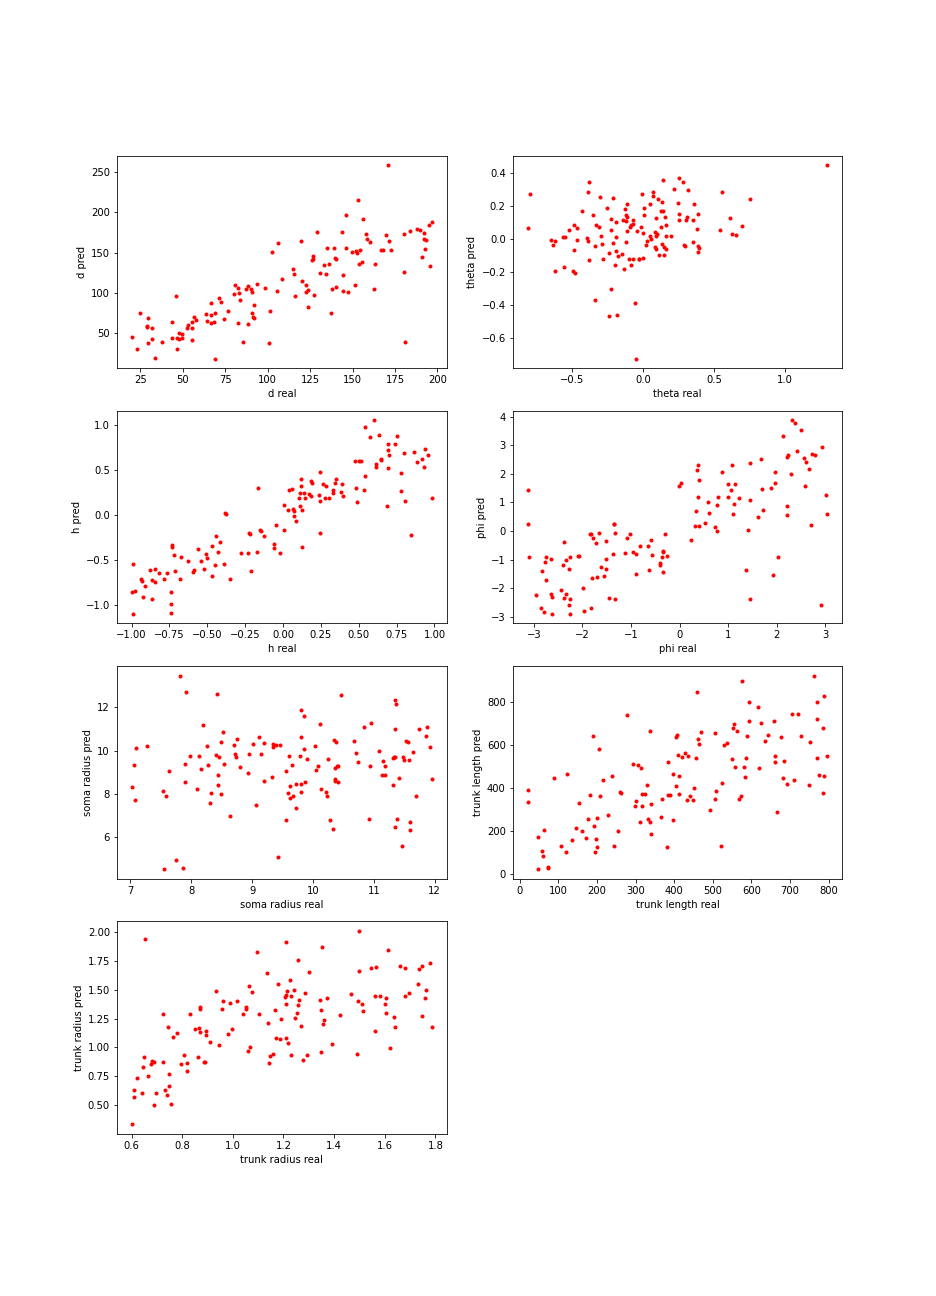

In [10]:
%matplotlib notebook

idx = 0

plt.figure(figsize=(13, 18))

ax_d = plt.subplot(421)
ax_d.scatter(y[:,0], output[:,0], c='red', marker='.')
ax_d.set_xlabel('d real')
ax_d.set_ylabel('d pred')

ax_t = plt.subplot(422)
ax_t.scatter(y[:,1], output[:,1], c='red', marker='.')
ax_t.set_xlabel('theta real')
ax_t.set_ylabel('theta pred')

ax_h = plt.subplot(423)
ax_h.scatter(y[:,2], output[:,2], c='red', marker='.')
ax_h.set_xlabel('h real')
ax_h.set_ylabel('h pred')

ax_p = plt.subplot(424)
ax_p.scatter(y[:,3], output[:,3], c='red', marker='.')
ax_p.set_xlabel('phi real')
ax_p.set_ylabel('phi pred')

ax_lt = plt.subplot(425)
ax_lt.scatter(y[:,4], output[:,4], c='red', marker='.')
ax_lt.set_xlabel('soma radius real')
ax_lt.set_ylabel('soma radius pred')

ax_lt = plt.subplot(426)
ax_lt.scatter(y[:,5], output[:,5], c='red', marker='.')
ax_lt.set_xlabel('trunk length real')
ax_lt.set_ylabel('trunk length pred')

ax_lt = plt.subplot(427)
ax_lt.scatter(y[:,6], output[:,6], c='red', marker='.')
ax_lt.set_xlabel('trunk radius real')
ax_lt.set_ylabel('trunk radius pred')


plt.show()

In [43]:
from cell_inference.utils.feature_extractors.SummaryStats2D import get_y_window

DATA_PATH = 'cell_inference/resources/invivo'

INVIVO_PATH = os.path.join(DATA_PATH, 'all_cell_LFP_2D.h5')

with h5py.File(INVIVO_PATH, "r") as f:
    c = f['coord'][:]
    d = f['data'][:]

test_data = []
summ_stats = []

for i in tqdm(range(d.shape[2])):
    g_lfp, g_coords = build_lfp_grid(lfp[i], params.ELECTRODE_POSITION, y_window_size=960.0)
    summ_stats.append(calculate_stats(g_lfp))
    test_data.append(g_lfp)

test_data = np.stack(test_data, axis=0)
summ_stats = np.stack(summ_stats, axis=0)

(802, 384, 383)


In [46]:
print(summ_stats.shape)

np.set_printoptions(suppress=True)

model1.eval()
summ_stats = torch.Tensor(summ_stats)
summ_stats_tensor = summ_stats.to(device)
pred = model1(summ_stats_tensor)
pred = np.squeeze(pred.to("cpu").detach().numpy())

print(pred.shape)

if normalize_labels:
    for i in range(pred.shape[1]):
        old_pred = pred[:,i]
        label_name = inference_list[i]
        min_max_range = ranges[label_name]
        org_pred = (((old_pred - feature_range[0]) / (feature_range[1] - feature_range[0])) 
                    * (min_max_range[1] - min_max_range[0]) + min_max_range[0])
        pred[:,i] = org_pred
        
pd.DataFrame(pred, columns = inference_list)

torch.Size([1, 383, 40])
(383, 7)


,d,theta,h,phi,r_s,l_t,r_t
0,56.678265,0.271432,0.287167,0.098135,11.439165,46.149933,1.198111
1,77.050156,-0.896036,-0.274041,0.910804,9.308865,399.412354,0.609981
2,165.030899,0.056060,-0.274347,0.438305,9.184237,755.444458,0.779290
3,147.563278,0.065380,-0.194271,0.614799,7.006520,511.526306,1.474711
4,88.510269,-0.190971,-0.975235,1.628090,11.323131,442.925049,0.868926
...,...,...,...,...,...,...,...
378,13.885851,0.083027,0.271589,-2.178212,10.747769,757.893372,0.632733
379,27.502365,-0.045007,0.654110,-1.990437,9.800411,734.246460,1.137812
380,89.433044,-0.445696,-0.631085,-2.172318,8.122912,89.998070,1.570144
381,22.800697,-0.076910,-0.908760,-2.269481,7.738505,231.299896,0.992138


(49, 176)
(49,)
(176,)


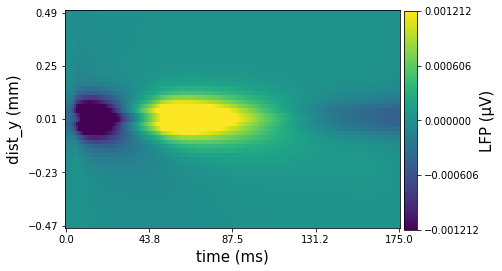

In [62]:
%matplotlib inline

cell_idx = 0

t = np.arange(test_data.shape[1])

ix = 1
ylim = [-1900,1900]
x_dist = np.unique(g_coords[:,0])
e_idx = ((g_coords[:,0]==x_dist[ix]) & 
         (g_coords[:,1]>=ylim[0]) & 
         (g_coords[:,1]<=ylim[1]))

print(test_data[0,:,e_idx].shape)
print(g_coords[e_idx, 1].shape)
print(t.shape)

_ = plot_lfp_heatmap(t,
                     g_coords[e_idx, 1],
                     np.transpose(test_data[0,:,e_idx]), vlim='auto',
                     fontsize=15,labelpad=0,ticksize=10,nbins=5)